Cat labels = 97, Dog labels = 101. <- Indicates mislabeling, supposed to be 99 of each!


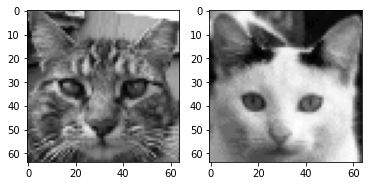

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

catsndogs = pd.read_csv('data\CATSnDOGS.csv')
labels = pd.read_csv('data\Labels.csv')


cat_ids = np.nonzero(labels.values[:,0]==0)[0] #[0] to get into tuple
dog_ids = np.nonzero(labels.values[:,0]==1)[0]

print(f'Cat labels = {len(cat_ids)}, Dog labels = {len(dog_ids)}. <- Indicates mislabeling, supposed to be 99 of each!')

catid = np.random.choice(cat_ids)
dogid = np.random.choice(dog_ids)

cat = catsndogs.iloc[catid].to_numpy().reshape((64,64), order='F')
dog = catsndogs.iloc[dogid].to_numpy().reshape((64,64), order='F')

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cat, cmap='gray')
axs[1].imshow(dog, cmap='gray')
plt.show()


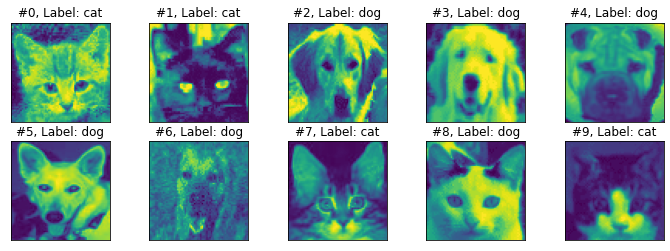

In [131]:
names = ['cat', 'dog']

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 4))

for i, axr in enumerate(axs):
    for j, ax in enumerate(axr):
        ax.imshow(catsndogs.iloc[i*len(axr)+j].to_numpy().reshape((64,64), order='F'))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax.set_title(f'#{i*len(axr)+j}, Label: {names[labels.values[i*len(axr)+j,0]]}')

# Question 1 (60p)



## 1a (10p)
 - Are the cats and dogs well separated, i.e. can you obtain good classification test accuracy performance on this data set? Compare at least 3 classifiers.

 - Are there any images that are consistently mislabeled by the classifiers (use resampling to ascertain)? Why do you think these are difficult images to classify? Do the classifiers struggle with the same observations?

 - Are the errors balanced or is one class more difficult to classify correctly?

In [215]:
# First we try to classify, using 3 classifiers
# Maybe Linear regression, QDA(?), and kNN?

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


x = catsndogs.to_numpy()
y = labels.values[:,0]
accuracy = {
    'knn': 0,
    'lr': 0,
    'rf': 0
}

mislabeled = {
    'knn': [],
    'lr': [],
    'rf': []
}
repetitions = 20


for i in range(repetitions):
    x_train, x_test, y_train, y_test = train_test_split(catsndogs, labels, test_size=0.2)

    # kNN
    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(x_train, y_train.values[:,0])
    y_pred = knn.predict(x_test)
    accuracy['knn'] += np.sum(y_pred==y_test.values[:,0])/len(y_test) /repetitions
    mislabeled['knn'].extend(y_test.index[(y_pred!=y_test.values[:,0])].to_list())

    # Linear regression
    lr = LogisticRegression(max_iter=500)
    lr.fit(x_train, y_train.values[:,0])
    y_pred = lr.predict(x_test)
    accuracy['lr'] += np.sum(y_pred==y_test.values[:,0])/len(y_test) /repetitions
    mislabeled['lr'].extend(y_test.index[(y_pred!=y_test.values[:,0])].to_list())

    # Random forest
    rf = RandomForestClassifier()
    rf.fit(x_train, y_train.values[:,0])
    y_pred = rf.predict(x_test)
    accuracy['rf'] += np.sum(y_pred==y_test.values[:,0])/len(y_test) /repetitions
    mislabeled['rf'].extend(y_test.index[(y_pred!=y_test.values[:,0])].to_list())

#print(accuracy)
#print(mislabeled)


In [231]:
#print(mislabeled['knn'])
occurences = {}
for key in mislabeled.keys():
    occurences[key] = np.bincount(mislabeled[key])

test = np.array(mislabeled['knn'])
print(np.unique(test[occurences['knn'][test]>2]))

# Verkar som att ovanstående test-grej borde funka för att 
# ta fram vilka bilder som är svåra att klassificera.
# TODO Kanske ta fram de 10-20 bilder (eller alla, men kan bli många) 
# som blir fel oftast, kolla vad anledningarna kan vara typ.
# Sen kanske jämföra mellan de olika, och se om det är samma bilder

[  5  18  25  37  39  47  58  69  71  77  85  93 103 112 113 114 117 125
 131 144 147 151 162 164 169 177 178 185]


For kNN with k=5 we get 0.75, logistic regression we get 0.74, and random forest gives 0.71. This is better than random, but not particularly good.